<a href="https://colab.research.google.com/github/aim56009/AI-MA_project/blob/main/Train_polyphonic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [29]:
%%capture
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import torchvision.transforms.functional as TF 

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import glob
import os
import random
import click
import sklearn
import sklearn.model_selection
from collections import defaultdict
from sklearn.metrics import accuracy_score
from pathlib import Path
import sys
from torch import optim
from torch.optim import lr_scheduler
from functools import partial
import matplotlib.pyplot as plt
#!pip install partitura
! pip install git+https://github.com/CPJKU/partitura.git@develop
import partitura
import statistics
import matplotlib



!git clone https://github.com/aim56009/AI-MA_project.git

#Dataloader - Set the dataset

In [30]:
PATH_TO_DATA = "AI-MA_project/pr_polyphonic"

batch_size = 1 
workers = 0

In [31]:
from scipy import sparse

In [32]:
max_len_load = 5000

class MusicDataset_polyphonic(Dataset):

    def __init__(self, data_dir, transforms=None):
        self.transforms = transforms
        self.data_dir = data_dir
        piece_lengths = ["2_voice","4_voice"]
        labels = ["voice_0", "voice_1", "voice_2", "voice_3", "voice_all"]
        self.labels = labels
        self.pr_dict = {}
        len_list = []
        nbr_voices_list = []
        file_names_list = []

        for v_len_idx in piece_lengths:
            if v_len_idx == "4_voice":
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))       
                        for name in file_names:
                            with open(name ,'rb') as f: ### normal sollte es egal sein wenn voice_4 bei manchen nicht existiert - wenn nicht condition einführen damit das funktioniert
                                loaded_obj = pickle.load(f)  

                                #print("loaded_obj before:",loaded_obj.shape)

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]
                            

                                #print("loaded_obj after:",loaded_obj.shape)

                                voice_files.append(sparse.csr_matrix(loaded_obj))

                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(4)                        

                        self.pr_dict[self.labels[iLabel]] += voice_files
                        self.pr_dict["length"] +=  len_list
                        self.pr_dict["nbr_voices"] +=  nbr_voices_list
                        self.pr_dict["name"] += file_names_list
                   
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]


                                  voice_files.append(sparse.csr_matrix(loaded_obj))
                        self.pr_dict[self.labels[iLabel]] += voice_files


            if v_len_idx == "2_voice":
                for iLabel in range(len(labels)):
                    if iLabel == 4:   
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA, v_len_idx , self.labels[iLabel], "*.pkl")))   
                        for name in file_names:
                            with open(name ,'rb') as f:
                                loaded_obj = pickle.load(f)  

                                pitch, t_len = loaded_obj.shape
                                if t_len > max_len_load:
                                  loaded_obj = loaded_obj[:,:max_len_load]

                                voice_files.append(sparse.csr_matrix(loaded_obj))
                                len_list.append(len(loaded_obj.T))
                                file_names_list.append(name[-7:-4])
                                nbr_voices_list.append(2)
                              
                        self.pr_dict[self.labels[iLabel]] = voice_files
                        self.pr_dict["length"] = len_list
                        self.pr_dict["nbr_voices"] = nbr_voices_list
                        self.pr_dict["name"] = file_names_list
    
                    else:
                        voice_files = []
                        file_names = sorted(glob.glob(os.path.join(PATH_TO_DATA,v_len_idx, self.labels[iLabel], "*.pkl"))) 
                        for name in file_names:
                            with open(name ,'rb') as f: 
                                  loaded_obj = pickle.load(f)   

                                  pitch, t_len = loaded_obj.shape
                                  if t_len > max_len_load:
                                    loaded_obj = loaded_obj[:,:max_len_load]

                                  voice_files.append(sparse.csr_matrix(loaded_obj))  
                        self.pr_dict[self.labels[iLabel]] = voice_files
                    
    def __len__(self):
        file_names_2 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "2_voice" , self.labels[4], "*.pkl")))
        file_names_4 = sorted(glob.glob(os.path.join(PATH_TO_DATA, "4_voice" , self.labels[4], "*.pkl")))
        return len(file_names_2) + len(file_names_4) 

    def __getitem__(self, idx):      
        out_list = []
        for key,value in self.pr_dict.items():
          v0 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_0"][idx]).T)
          v1 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_1"][idx]).T)
          
          if self.pr_dict["nbr_voices"][idx] == 4:       ### -168 WORKS ONLY IN THIS CASE BC 168 SAMPLES OF LEN(2) ARE LOADED FIRST
              v2 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_2"][idx-168]).T)
              v3 = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_3"][idx-168]).T)
          if self.pr_dict["nbr_voices"][idx] == 2:
              v2 = torch.zeros(v1.shape)
              v3 = torch.zeros(v1.shape)
          
          v_all = torch.tensor(sparse.csr_matrix.todense(self.pr_dict["voice_all"][idx]).T)
          length = self.pr_dict["length"][idx]
          nbr_voices = self.pr_dict["nbr_voices"][idx]
          file_name = self.pr_dict["name"][idx]
          voices = torch.stack([v0, v1, v2, v3, v_all], dim=2)

        return (voices, length, nbr_voices, file_name)

In [33]:
"""
dataset = MusicDataset_polyphonic(PATH_TO_DATA)
loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\ndataset = MusicDataset_polyphonic(PATH_TO_DATA)\nloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)\n\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [34]:
"""
for i, sample_batched in enumerate(loader):
    if i == 168:
        all_voices, length, nbr_voices, file_name = sample_batched
        print(file_name[0],nbr_voices,all_voices.shape)
        break
"""

'\nfor i, sample_batched in enumerate(loader):\n    if i == 168:\n        all_voices, length, nbr_voices, file_name = sample_batched\n        print(file_name[0],nbr_voices,all_voices.shape)\n        break\n'

In [35]:
"""
pianoroll_0 = all_voices.squeeze()[:,:,0].numpy()
pianoroll_1 = all_voices.squeeze()[:,:,1].numpy()
pianoroll_2 = all_voices.squeeze()[:,:,2].numpy()
pianoroll_3 = all_voices.squeeze()[:,:,3].numpy()
pianoroll_all = all_voices.squeeze()[:,:,-1].numpy()

colors_0 = 'none red'.split()
colors_1 = 'none green'.split()
colors_2 = 'none blue'.split()
colors_3 = 'black orange'.split()

cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)
cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_1[3000:4000,:], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
ax.imshow(pianoroll_0[3000:4000,:], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
ax.set_xlabel(f'Time ({"beat"}s/{12})')
ax.set_ylabel('Piano key')
plt.show()
"""

'\npianoroll_0 = all_voices.squeeze()[:,:,0].numpy()\npianoroll_1 = all_voices.squeeze()[:,:,1].numpy()\npianoroll_2 = all_voices.squeeze()[:,:,2].numpy()\npianoroll_3 = all_voices.squeeze()[:,:,3].numpy()\npianoroll_all = all_voices.squeeze()[:,:,-1].numpy()\n\ncolors_0 = \'none red\'.split()\ncolors_1 = \'none green\'.split()\ncolors_2 = \'none blue\'.split()\ncolors_3 = \'black orange\'.split()\n\ncmap_0 = matplotlib.colors.ListedColormap(colors_0, name=\'colors\', N=None)\ncmap_1 = matplotlib.colors.ListedColormap(colors_1, name=\'colors\', N=None)\ncmap_2 = matplotlib.colors.ListedColormap(colors_2, name=\'colors\', N=None)\ncmap_3 = matplotlib.colors.ListedColormap(colors_3, name=\'colors\', N=None)\n\nfig, ax = plt.subplots(1, figsize=(20, 10))\n\nax.imshow(pianoroll_3[3000:4000,:], origin="lower", cmap=cmap_3, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(pianoroll_2[3000:4000,:], origin="lower", cmap=cmap_2, interpolation=\'nearest\', aspect=\'auto\')\nax.imshow(piano

#Define U-Net

In [36]:
class UNET(nn.Module):
    
    def __init__(self, in_channels=1, classes=1):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList([self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList([nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2) for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList([self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        #print("x shape before",x.shape)
        for down in self.double_conv_downs:
            x = down(x)
            #print("x shape down",x.shape)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
                #print("if down conv:", x.shape)
            #print("x shape after:", x.shape)
        y = x
        #print("y after one out", y.shape)
        concat_layers = concat_layers[::-1]

        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x, y

# Define Network


In [37]:
class MusicNetwork(nn.Module):

    def __init__(self, network_type,output_dim=88, hidden_dim=300, rnn_depth=1, cell_type="GRU"):                 
        super(MusicNetwork, self).__init__()

        self.network_type = network_type
        self.n_out = output_dim
        input_dim = output_dim 
        rnn_cell = nn.GRU
        self.rnn = rnn_cell(input_size=input_dim, hidden_size=hidden_dim, num_layers=rnn_depth, batch_first=True)
        self.cnn = UNET(in_channels=1, classes=4)
        self.top_layer_voice_0 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_1 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_2 = nn.Linear(hidden_dim, self.n_out)
        self.top_layer_voice_3 = nn.Linear(hidden_dim, self.n_out)

        self.input_unet = int(np.floor(max_len_load/2/2/2/2)*1024*5)
        self.clf_head = nn.Linear(self.input_unet, 4)                         ################   4 bc max nbr voices ==4 in our dataset
        self.indicator = 0

    

    def compute_outputs(self, sentences, sentences_len):
        if self.network_type == "RNN":
          rnn_out ,_= self.rnn(sentences)     
          out_0 = self.top_layer_voice_0(rnn_out)
          out_1 = self.top_layer_voice_1(rnn_out)
          out_2 = self.top_layer_voice_2(rnn_out)
          out_3 = self.top_layer_voice_3(rnn_out)

          return torch.stack([out_0, out_1, out_2, out_3], dim=1)

        else: 
          sentences = sentences[:,None]
          out, down_state = self.cnn(sentences)

          self.down_state = down_state
          if self.input_unet == torch.flatten(down_state).shape[0]:
            self.indicator = 1
            out_clf_head = self.clf_head(torch.flatten(down_state))
            return out, out_clf_head                
          else:      ### in case input is smaller than 5000
            self.indicator = 0
            return out, None                                      
        

    def forward(self, voices, sentences_len, nbr_voices):            
        # Compute the outputs. The shape is (max_len, n_sentences, n_labels).
        scores_comb, out_clf_head = self.compute_outputs(voices[:,:,:,-1], sentences_len)

        # Flatten the outputs and the labels, to compute the loss.
        # The input to this loss needs to be one 2-dimensional and one 1-dimensional tensor.
        score_0  = scores_comb[:,0,:,:].view(-1, self.n_out)
        score_1  = scores_comb[:,1,:,:].view(-1, self.n_out)
        score_2  = scores_comb[:,2,:,:].view(-1, self.n_out)
        score_3  = scores_comb[:,3,:,:].view(-1, self.n_out)

        if self.indicator ==0:
          loss_clf = 0
        else:
          clf_score = out_clf_head.softmax(dim=0)
          clf_label = nbr_voices[0]-1
          define_clf_loss = nn.CrossEntropyLoss(reduction='mean')
          loss_clf = define_clf_loss(clf_score, clf_label)

        print("loss_clf",loss_clf)
 

        weight_v0 = voices[:,:,:,0].squeeze().sum()
        weight_v1 = voices[:,:,:,1].squeeze().sum()
        weight_v2 = voices[:,:,:,2].squeeze().sum()
        weight_v3 = voices[:,:,:,3].squeeze().sum()

        stack_tensors_gt = torch.swapaxes(torch.swapaxes(voices[:,:,:,:4].squeeze(), 0, 2), 1,2)
        stack_gt = torch.argmax(stack_tensors_gt,axis=0)

        
        weight_tensor = torch.stack([weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0,weight_v0/weight_v0])
        criterion_weighted = nn.CrossEntropyLoss(weight=weight_tensor,reduction='mean',ignore_index=99)  
        stack_pred = torch.stack([score_0, score_1, score_2, score_3], dim=0).softmax(dim=0)[None, :]
        mask_pred = torch.squeeze(voices[:,:,:,-1])== 0
        stack_gt[mask_pred] = 99
        loss = criterion_weighted(stack_pred, stack_gt[None,:])

        if torch.any(torch.isnan(stack_pred)) or torch.any(torch.isinf(stack_pred)) :
          print('invalid input detected at iteration ')

        return loss + loss_clf


    def predict(self, sentences, sentences_len,monophonic=True):
        scores_comb, out_clf_head = self.compute_outputs(sentences, sentences_len)
        sum_tensor = scores_comb * sentences[:,None,:,:]
        prediction = np.squeeze(sum_tensor.cpu().numpy())                # prediction is of shape 4,T,88 and contains a probability for the result to belong to one of the 4 voices -> taking argmax: gives the voice with the highes probability
        v_pred_argm = torch.tensor(np.argmax(prediction,axis=0))
        
        mask_pred = np.squeeze(sentences)== 0
        v_pred_argm[mask_pred] = -1

        ### only output if clf is not none ####       ####!!!!!!!!!NNEEEED TO TEST AGAIN !!!!
        if out_clf_head != None:
          clf_score = out_clf_head.softmax(dim=0)
          pred_clf = torch.argmax(clf_score,axis=0)              
        else:      
          pred_clf = 0
                
        #clf_score = out_clf_head.softmax(dim=0)
        #pred_clf = torch.argmax(clf_score,axis=0)

        return v_pred_argm, pred_clf   

In [38]:
"""
monophonic = True
his = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)
"""

'\nmonophonic = True\nhis = start_experiment(1, 0.001, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, "CNN", learn_all)\n'

# Define Training Process

In [39]:
def train(epochs, lr, hidden_dim, momentum, rnn_depth, device, rnn_cell, weight_decay,network_type, train_dataloader, val_dataloader=None):
    
    output_dim = 88
    model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)              
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.MultiStepLR(optimizer, [epochs // 2], gamma=0.1, verbose=True)

    history = training_loop(model, optimizer, train_dataloader,monophonic, epochs=epochs, val_dataloader=val_dataloader, device=device, scheduler=scheduler)

    return model, history

# Tryining Loop

In [40]:
#### versuch hier mal nur für 4 voices zu trainieren

def training_loop(model,optimizer, train_dataloader, monophonic, epochs=50, val_dataloader=None, device=None, scheduler=None):
    if device is None:
        device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
        print(f"Training on device: {device}")

    model = model.to(device)
    history = defaultdict(list)

    for i_epoch in range(1, epochs + 1):
        loss_sum = 0
        loss_sum_clf = 0
        model.train()
                
        for idx, (voices, lens, nbr_voices, _) in enumerate(train_dataloader):  
            if nbr_voices == 4:
              voices = voices.to(device).float()
              optimizer.zero_grad()
              loss = model.forward(voices, lens, nbr_voices)             
              print("loss:",loss)
              loss.backward()
              optimizer.step()
              loss_sum += loss.item()  

        train_loss = loss_sum / len(train_dataloader)
        print("Epoch: {}, Train Loss: {}".format(i_epoch,train_loss)) 

        if scheduler is not None:
            scheduler.step()
        
    torch.save({'model_state_dict': model.state_dict()}, Path("./AI-MA_project/model_temp_epoch{}.pkl".format(i_epoch)))

    return history

In [41]:
def start_experiment( epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell, decay,network_type, learn_all):
    
    trainer = partial(train,epochs, lr, hidden_dim, momentum, rnn_depth, device, cell, decay, network_type)

    if learn_all == True:
        print("Learning from full dataset")
        train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        _, history = trainer(train_dataloader)

    
    else:
        # Divide train and validation set
        dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
        train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
        val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

        print("train_dataloader",len(train_dataloader),"val_dataloader",len(val_dataloader))
        _, history = trainer(train_dataloader, val_dataloader)

    return history, val_dataloader

# Hyperparameter choice

In [42]:
model = MusicNetwork
epochs = 1
lr = 0.001 # was 0.001    #0.00001
momentum = 0.9
decay = 1e-4
hidden_dim = 300
bs = 1
rnn_depth = 2 
device = None                 #if None:  choses device automatically
cell_type = "GRU"
optimizer = "Adam"
learn_all = "False"           # False -> uses train and valid set
network_type= "CNN" # with clf head: "CNN_CLF"

monophonic = True

# Run the experiment

In [43]:
his, val_dataloader = start_experiment(epochs, lr, hidden_dim, bs, momentum, rnn_depth, device, cell_type, decay, network_type, learn_all)

train_dataloader 199 val_dataloader 36
Adjusting learning rate of group 0 to 1.0000e-04.
Training on device: cpu
loss_clf tensor(1.3871, grad_fn=<NllLossBackward0>)
loss: tensor(2.7889, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.1279, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.1224, grad_fn=<AddBackward0>)
loss_clf 0
loss: tensor(1.3761, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.1245, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.1181, grad_fn=<AddBackward0>)
loss_clf 0
loss: tensor(1.3709, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.1016, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.0986, grad_fn=<AddBackward0>)
loss_clf tensor(0.7437, grad_fn=<NllLossBackward0>)
loss: tensor(2.0990, grad_fn=<AddBackward0>)

# Load trained model

In [44]:
dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataset, validation_dataset = sklearn.model_selection.train_test_split(dataset, test_size=0.15, random_state=10,)
#train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)
val_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)


In [45]:
train_dataset = MusicDataset_polyphonic(PATH_TO_DATA) 
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=False, num_workers=workers, drop_last=True)

val_dataloader 

In [46]:
len(val_dataloader)

36

In [47]:
%%capture  
output_dim = 88
model = MusicNetwork(network_type, output_dim, hidden_dim, rnn_depth, cell_type)  
checkpoint = torch.load("./AI-MA_project/model_temp_epoch1.pkl")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create dic with key:filename, val: part_obj  

In [48]:
#%%capture

path_parts = "AI-MA_project/polyphonic_new"
part_dic = {}

#### create a list with all filenames in the right order ####
file_names_part = []

for filename in sorted(os.listdir(path_parts)):
    if not filename.endswith('.mid'): continue
    file_names_part.append(filename[9:12])
print(file_names_part)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145'

# Compute polyphonic accuracy

In [49]:
def evaluate_accuracy_polyphonic_separate(model, train_dataloader, part_dic,print_predictions=False):

    unitl_len_idx = max_len_load

    path_parts = "AI-MA_project/polyphonic_new"
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    acc_score_dict_two = {'0': [], '1': [] }
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
                                      
                #print("nbr_voices:",nbr_voices)
        if idx not in [0, 7, 8, 15, 21, 25, 32, 35]:   

            if nbr_voices == 4:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                part_2 = part[2]
                part_3 = part[3]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)              
                note_array_2 = partitura.utils.note_array_from_part(part_2)
                note_array_3 = partitura.utils.note_array_from_part(part_3)

                list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
            
                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)


                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]
                        print("prediction clf:",prediction_clf)

                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)

                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")

                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (10, 5)

                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')

                    ax.set_title("PREDICTED: red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()

                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()
                    pr_two = partitura.utils.compute_pianoroll(part_2, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_two = pr_two.toarray()
                    pr_three = partitura.utils.compute_pianoroll(part_3, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_three = pr_three.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_two[:,:unitl_len_idx], origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_three[:,:unitl_len_idx], origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')
                    
                    
                        
                    ax.set_title("ORIGINAL: red-v0, green-v1 ,blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key' )
                    plt.show()

                    count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                    for gt, i in enumerate(total_predictions_dict.keys()):
                      counting = 0
                      for j in range(len(total_predictions_dict[i])):
                          if total_predictions_dict[i][j][0] == gt:         
                            counting +=1
                      count_dict_2[i].append(counting)


                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                
                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                print("acc 2, sample {}:".format(idx),acc_2)
                print("acc 3, sample {}:".format(idx),acc_3)

                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                acc_score_dict["2"].append(acc_2)
                acc_score_dict["3"].append(acc_3)



            if nbr_voices == 2:
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                
                list_of_note_arrays_2 = [note_array_0,note_array_1]

                
                ground_truth_label_list_2 = [0,1]              
                total_predictions_dict_2 = {'0': [], '1': [] }
                total_truth_dict_2 = {'0': [], '1': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays_2):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)


                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)   
                        label = ground_truth_label_list_2[el_note_arr]
                        print("prediction clf:",prediction_clf)


                    for i in range(len(note_idx_start)):
                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        total_predictions_dict_2[str(label)].append(pred_list_first)
                        total_truth_dict_2[str(label)].append(truth_list)

                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")

                if print_predictions == True:
                    #################### print pr ####################
                    fig_size_1 = (10, 5)
                    prediction_0 = np.where(prediction ==0, 1, 0)
                    prediction_1 = np.where(prediction ==1, 1, 0)
                    prediction_2 = np.where(prediction ==2, 1, 0)
                    prediction_3 = np.where(prediction ==3, 1, 0)

                    ####### print predicte pr #######                  
                    colors_0 = 'black red'.split()
                    colors_1 = 'none green'.split()  
                    colors_2 = 'none blue'.split() 
                    colors_3 = 'none orange'.split()                
                    cmap_0 = matplotlib.colors.ListedColormap(colors_0, name='colors', N=None)        
                    cmap_1 = matplotlib.colors.ListedColormap(colors_1, name='colors', N=None)
                    cmap_2 = matplotlib.colors.ListedColormap(colors_2, name='colors', N=None)
                    cmap_3 = matplotlib.colors.ListedColormap(colors_3, name='colors', N=None)

                    fig, ax = plt.subplots(1, figsize=fig_size_1)

                    ax.imshow(prediction_0.T, origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto') 
                    ax.imshow(prediction_1.T, origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')   
                    ax.imshow(prediction_2.T, origin="lower", cmap=cmap_2, interpolation='nearest', aspect='auto')
                    ax.imshow(prediction_3.T, origin="lower", cmap=cmap_3, interpolation='nearest', aspect='auto')

                    ax.set_title("PREDICTED: 2 piece red-v0, green-v1, blue-v2, orange-v3")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()



                    ####### print original pr #######
                    onset_beat = partitura.utils.ensure_notearray(part)['onset_beat'][-1]
                    duration_beat = partitura.utils.ensure_notearray(part)['duration_beat'][-1]
                    beat_all = onset_beat + duration_beat
                    pr_zero = partitura.utils.compute_pianoroll(part_0, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_zero = pr_zero.toarray()
                    pr_one = partitura.utils.compute_pianoroll(part_1, time_unit = "beat",time_div = 12,piano_range=True,remove_silence=False,end_time=beat_all)
                    pr_one = pr_one.toarray()

                    fig, ax = plt.subplots(1, figsize=fig_size_1)
                    ax.imshow(pr_zero[:,:unitl_len_idx], origin="lower", cmap=cmap_0, interpolation='nearest', aspect='auto')
                    ax.imshow(pr_one[:,:unitl_len_idx], origin="lower", cmap=cmap_1, interpolation='nearest', aspect='auto')
                        
                    ax.set_title("ORIGINAL: 2 piece red-v0, green-v1")                
                    ax.set_xlabel(f'Time ({"beat"}s/{12})')
                    ax.set_ylabel('Piano key')
                    plt.show()

                count_dict_22 = {'0': [], '1': [] }
                for gt, i in enumerate(total_predictions_dict_2.keys()):
                  counting = 0
                  for j in range(len(total_predictions_dict_2[i])):
                      if total_predictions_dict_2[i][j][0] == gt:       
                        counting +=1
                  count_dict_22[i].append(counting)

          
                acc_0_2 = count_dict_22["0"][0]/len(total_predictions_dict_2["0"])
                acc_1_2 = count_dict_22["1"][0]/len(total_predictions_dict_2["1"])
                
                print("acc_0_2, sample {}:".format(idx),acc_0_2)
                print("acc_1_2, sample {}:".format(idx),acc_1_2)
                
                acc_score_dict_two["0"].append(acc_0_2)
                acc_score_dict_two["1"].append(acc_1_2)

                
                
    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict_two["0"]), statistics.mean(acc_score_dict_two["1"]), statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])

/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=78 velocity=64 time=228
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=78
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=66 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=64 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=0
  warnings.warn("ignoring MIDI messag

prediction clf: tensor(3)
prediction clf: tensor(3)


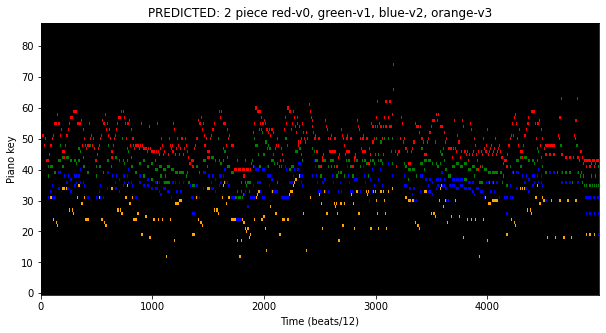

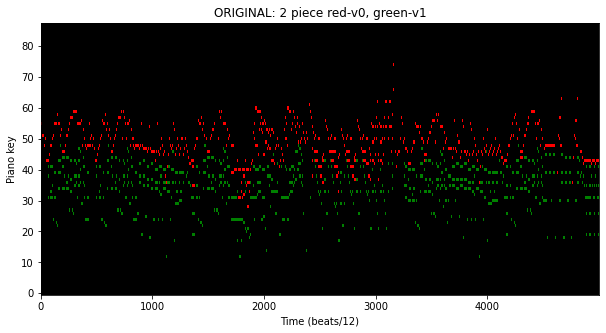

acc_0_2, sample 1: 0.8423841059602649
acc_1_2, sample 1: 0.32156368221941994


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=78 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=119
  warnings.warn("ignoring MIDI message %s" % msg)


prediction clf: tensor(3)
prediction clf: tensor(3)


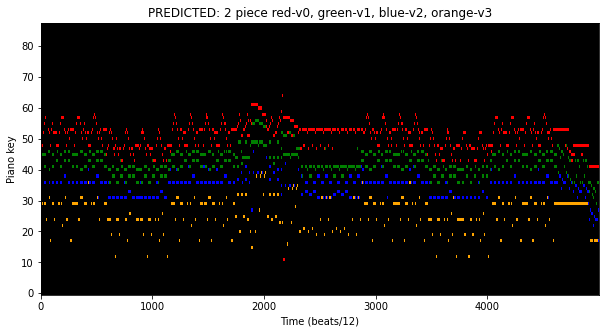

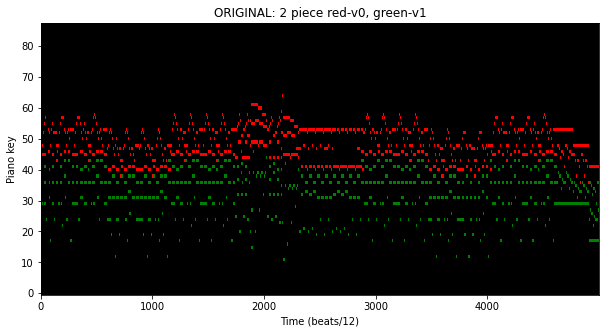

acc_0_2, sample 2: 0.6429961089494164
acc_1_2, sample 2: 0.2783018867924528


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=44 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=42 velocity=64 time=90
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=37 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=37 velocity=64 time=90
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: voice estimation
  app.launch_new_instance()


AttributeError: ignored

In [50]:
dict_pred , dict_gt, acc_0_2, acc_1_2, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)

print("acc_0_2:",acc_0_2)
print("acc_1_2:",acc_1_2)
print("acc_0:",acc_0)
print("acc_1:",acc_1)
print("acc_2:",acc_2)
print("acc_3:",acc_3)

/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=78 velocity=64 time=228
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=69 velocity=64 time=78
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=66 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=64 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=73 velocity=64 time=0
  warnings.warn("ignoring MIDI messag

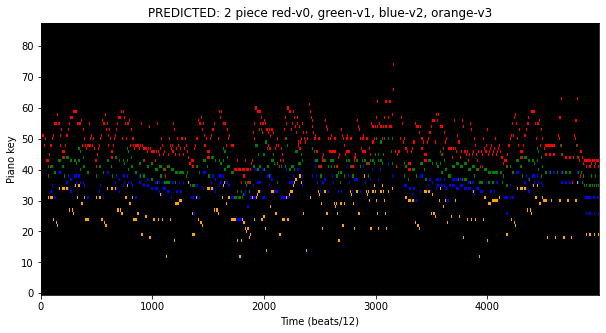

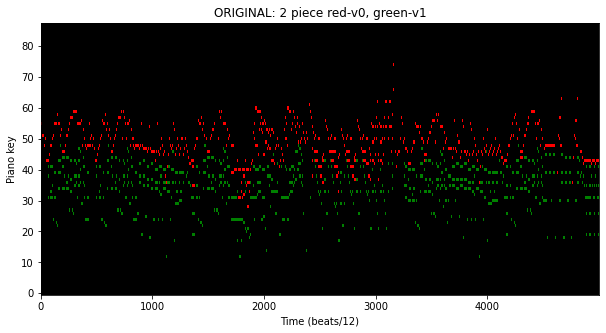

acc_0_2, sample 1: 0.8781456953642384
acc_1_2, sample 1: 0.3379571248423707


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=0 note=78 velocity=64 time=108
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_on channel=0 note=0 velocity=0 time=119
  warnings.warn("ignoring MIDI message %s" % msg)


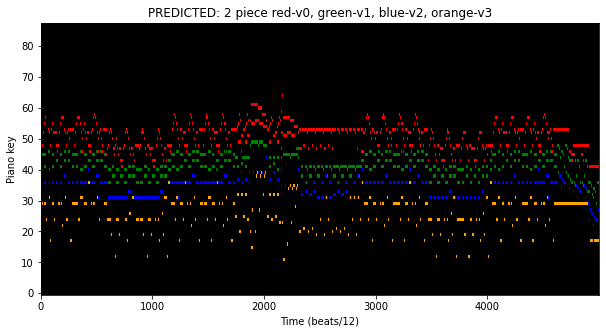

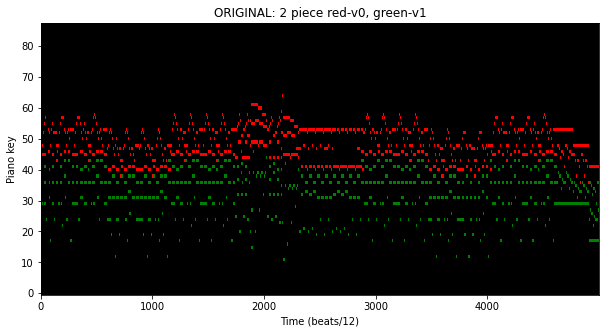

acc_0_2, sample 2: 0.6984435797665369
acc_1_2, sample 2: 0.30778301886792453


/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=44 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=42 velocity=64 time=90
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=37 velocity=64 time=0
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/partitura/io/importmidi.py:360: UserWarning: ignoring MIDI message note_off channel=4 note=37 velocity=64 time=90
  warnings.warn("ignoring MIDI message %s" % msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: voice estimation
  app.launch_new_instance()


NameError: ignored

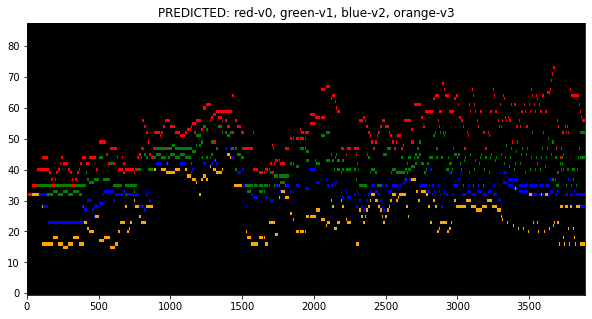

In [ ]:
dict_pred , dict_gt, acc_0_2, acc_1_2, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic_separate(model,val_dataloader,part_dic=file_names_part,print_predictions=True)

print("acc_0_2:",acc_0_2)
print("acc_1_2:",acc_1_2)
print("acc_0:",acc_0)
print("acc_1:",acc_1)
print("acc_2:",acc_2)
print("acc_3:",acc_3)

# Accuracy mixed all voices (old)

In [ ]:
def evaluate_accuracy_polyphonic(model, train_dataloader, part_dic):

    unitl_len_idx = max_len_load
    path_parts = "AI-MA_project/polyphonic_new"
    acc_score_dict = {'0': [], '1': [], '2': [], '3': [] }
    for idx, (voices, lens, nbr_voices, file_name) in enumerate(train_dataloader):
                                      
                #print("nbr_voices:",nbr_voices)
        if idx >30 and idx not in [0, 7, 21, 32, 35]: 
            #if nbr_voices == 2:
                
                file_name = file_name[0]
                filename_part = os.path.join(path_parts, "part_file" + file_name + ".mid")
                part = partitura.load_score_midi(filename_part)

                part_0 = part[0]
                part_1 = part[1]
                
                note_array_0 = partitura.utils.note_array_from_part(part_0)
                note_array_1 = partitura.utils.note_array_from_part(part_1)
                

                list_of_note_arrays = [note_array_0,note_array_1]

                if len(part)== 4:
                    part_2 = part[2]
                    note_array_2 = partitura.utils.note_array_from_part(part_2)

                    part_3 = part[3]
                    note_array_3 = partitura.utils.note_array_from_part(part_3)
                    list_of_note_arrays = [note_array_0,note_array_1,note_array_2,note_array_3]
                
                ground_truth_label_list = [0,1,2,3]              
                total_predictions_dict = {'0': [], '1': [], '2': [], '3': [] }
                total_truth_dict = {'0': [], '1': [], '2': [], '3': [] }
                accordance_dict = {'0': [], '1': [], '2': [], '3': [] }
            

                for el_note_arr, note_array in enumerate(list_of_note_arrays):
                    onset_beat = note_array["onset_beat"]
                    duration_beat = note_array["duration_beat"]
                    pitch_list = note_array["pitch"]
                    pitch_list = pitch_list - 21             
                    note_idx_start = 12 * onset_beat
                    note_idx_end = 12 * (onset_beat+duration_beat)

                    

                    ### round every entry up to next integer for the starting idx ###
                    note_idx_start = [int(np.ceil(num)) for num in note_idx_start]                      # do this fur whole np array np.ceil(note_idx_start)
                    ### round every entry down to next integer for the ending idx###
                    note_idx_end = [int(np.floor(num)) for num in note_idx_end]

                               
                    # do model prediction
                    model.eval()
                    voices = voices.to(device).float()
                    monophonic=True
                    with torch.no_grad():
                        prediction, prediction_clf = model.predict(voices[:,:,:,-1], lens, monophonic)  
                        label = ground_truth_label_list[el_note_arr]
                        print("prediction clf:",prediction_clf)


                
                    for i in range(len(note_idx_start)):

                        start_first = note_idx_start[i]
                        end_first =  note_idx_end[i]   

                        if end_first <= unitl_len_idx:
                          #print("stop",end_first)
                          pitch_first = pitch_list[i]
                          pred_list_first = prediction[start_first:end_first,pitch_first]
                          truth_list = [label for i in range(len(pred_list_first))]
              
                          result = all(elem == pred_list_first[0] for elem in pred_list_first)
                          # do majority vote if not all predictions are for same voice
                          if result == False:
                              major, major_idx = torch.mode(pred_list_first,0)
                              major = major.numpy().tolist()
                              pred_list_first = [major for i in pred_list_first]

                        
                        total_predictions_dict[str(label)].append(pred_list_first)
                        total_truth_dict[str(label)].append(truth_list)

                        #print("pred_list",str(label),len(pred_list_first),pred_list_first)
                        if len(pred_list_first)==0:
                          print("ATTENTION:", len(pred_list_first),str(label) )
                          print("index:", idx)
                          print("------------------------------------------------------------------------")
                          print("total_predictions_dict",str(label),len(pred_list_first),pred_list_first)




                count_dict_2 = {'0': [], '1': [], '2': [], '3': [] }

                for gt, i in enumerate(total_predictions_dict.keys()):
                  counting = 0
                  for j in range(len(total_predictions_dict[i])):
                      if total_predictions_dict[i][j][0] == gt:         
                        counting +=1
                  count_dict_2[i].append(counting)



                acc_0 = count_dict_2["0"][0]/len(total_predictions_dict["0"])
                acc_1 = count_dict_2["1"][0]/len(total_predictions_dict["1"])
                

                print("acc 0, sample {}:".format(idx),acc_0)
                print("acc 1, sample {}:".format(idx),acc_1)
                

                if len(list_of_note_arrays)==4:
                    acc_2 = count_dict_2["2"][0]/len(total_predictions_dict["2"])
                    print("acc 2, sample {}:".format(idx),acc_2)
                    acc_score_dict["2"].append(acc_2)

                    acc_3 = count_dict_2["3"][0]/len(total_predictions_dict["3"])
                    print("acc 3, sample {}:".format(idx),acc_3)
                    acc_score_dict["3"].append(acc_3)


                acc_score_dict["0"].append(acc_0)
                acc_score_dict["1"].append(acc_1)
                

                
    print("total_predictions_dict",total_predictions_dict.keys())

    return total_predictions_dict, total_truth_dict, statistics.mean(acc_score_dict["0"]), statistics.mean(acc_score_dict["1"]), statistics.mean(acc_score_dict["2"]),statistics.mean(acc_score_dict["3"])

In [ ]:
dict_pred , dict_gt, acc_0 , acc_1, acc_2, acc_3 = evaluate_accuracy_polyphonic(model,val_dataloader,part_dic=file_names_part)


print("acc_0:",acc_0)
print("acc_1:",acc_1)
print("acc_2:",acc_2)
print("acc_3:",acc_3)